## Probabilistic Programming 2: Message Passing & Analytical Bayesian Solutions

#### Goal 
  - Understand when and how analytical solutions to Bayesian inference can be obtained.
  - Understand how to perform message passing in a Forney-style factor graph.

#### Materials        
  - Mandatory
    - This notebook
    - Lecture notes on factor graphs
    - Lecture notes on continuous data
    - Lecture notes on discrete data
  - Optional
    - Chapters 2 and 3 of [Model-Based Machine Learning](http://www.mbmlbook.com/LearningSkills.html).
    - [Differences between Julia and Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

Note that none of the material used below is new. The point of the Probabilistic Programming sessions is to solve practical problems so that the concepts introduced in Bert's lectures become less abstract.

In [36]:
using LinearAlgebra
using SpecialFunctions
using ForneyLab
using Plots

We'll be using the toolbox [ForneyLab.jl](https://github.com/biaslab/ForneyLab.jl) to visualize factor graphs and compute messages passed within the graph.

## Problem: Measuring skill

Measuring a person's skill is an important but tricky task. Even a highly-skilled person makes mistakes and people with little skills can get lucky. In this session, we will looking at various ways to assess skill using questions and test assignments. Along the way, you will gain experience with message passing, factor graphs and discrete vs continuous data.

### 1: Right or wrong

Suppose you head to a job interview for a machine learning engineer position. The company is interested in someone who knows Julia and has set up a test with syntax questions. We will first look at a single question, which we treat as an outcome variable $Q_1$. You can either get this question right or wrong, which means we're dealing with a Bernoulli likelihood. The company assumes you have a skill level, denoted $\theta$, and the higher the skill, the more likely you are to get the question right. Since the company doesn't know anything about you, they chose an uninformative prior distribution: the _Beta(1,1)_. We can write the generative model for answering this question as follows:

$$\begin{align}
p(Q_1, \theta) = p(Q_1 \mid \theta) \cdot p(\theta)
\end{align}$$

where $p(Q_1 \mid \theta) = \text{Bern}(Q_1 \mid \theta)$ and $p(\theta) = \text{Beta}(\theta \mid 1,1)$. We are now going to map this model to a Forney-style factor graph using the toolbox ForneyLab.

In [4]:
# Start building a model by setting up a FactorGraph structure
factor_graph1 = FactorGraph()

# Add the prior over 
@RV θ ~ Beta(1.0, 1.0, id=:prior)

# Add the question correctness likelihood
@RV Q1 ~ Bernoulli(θ, id=:likelihood)

# The outcome Q1 is going to be observed, so we set up a placeholder for the data entry
placeholder(Q1, :Q1)

# Visualize the graph
ForneyLab.draw(factor_graph1)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 1537216325021298444 -->
 
 1537216325021298444 
 
 Beta 
 prior 
 
<!-- 1352294244770636634 -->
 
 1352294244770636634 
 
 clamp_2 
 
<!-- 1537216325021298444--1352294244770636634 -->
 
 1537216325021298444--1352294244770636634 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 17321053194984288992 -->
 
 17321053194984288992 
 
 clamp_1 
 
<!-- 1537216325021298444--17321053194984288992 -->
 
 1537216325021298444--17321053194984288992 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 13496785491452164775 -->
 
 13496785491452164775 
 
 placeholder_Q1 
 
<!-- 13181136101657230830 -->
 
 13181136101657230830 
 
 Ber 
 likelihood 
 
<!-- 13496785491452164775--13181136101657230830 -->
 
 13496785491452164775--13181136101657230830 
 
 Q1 
 1 out 
 1 out 
 
<!-- 13181136101657230830--1537216325021298444 -->
 
 13181136101657230830--1537216325021298444 
 
 θ 
 1 out 
 2 p

Code notes:
- @RV is a macro that lets you Random Variables to your graph
- ~ means "is distributed as". For example, $\theta$ "is distributed as" a Beta(1,1) distribution.

Above you can see the factor graph that ForneyLab has generated. It is not as clean as the ones in the theory lectures, but the annotations are useful for debugging later on. We are now going to ask ForneyLab to generate a message passing procedure for us.

In [5]:
# Indicate which variables you want posteriors for
q = PosteriorFactorization(θ, ids=[:θ])

# Generate a message passing inference algorithm
algorithm = messagePassingAlgorithm(θ, q)

# Compile algorithm code
source_code = algorithmSourceCode(algorithm)

# Bring compiled code into current scope
eval(Meta.parse(source_code))

# Visualize message passing schedule
pfθ = q.posterior_factors[:θ]
ForneyLab.draw(pfθ, schedule=pfθ.schedule);

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 1537216325021298444 -->
 
 1537216325021298444 
 
 Beta 
 prior 
 
<!-- 1352294244770636634 -->
 
 1352294244770636634 
 
<!-- 1537216325021298444--1352294244770636634 -->
 
 1537216325021298444--1352294244770636634 
 
 1 out 
 3 b 
 
<!-- 17321053194984288992 -->
 
 17321053194984288992 
 
<!-- 1537216325021298444--17321053194984288992 -->
 
 1537216325021298444--17321053194984288992 
 
 1 out 
 2 a 
 
<!-- 13181136101657230830 -->
 
 13181136101657230830 
 
 Ber 
 likelihood 
 
<!-- 13181136101657230830--1537216325021298444 -->
 
 13181136101657230830--1537216325021298444 
 
 θ 
 1 out 
 ((1)) 
 2 p 
 ((2)) 
 
<!-- 13496785491452164775 -->
 
 13496785491452164775 
 
<!-- 13496785491452164775--13181136101657230830 -->
 
 13496785491452164775--13181136101657230830 
 
 1 out 
 1 out

ForneyLab's visualization of the message passing procedure for a specific variable isolates that variable in the graph and shows where the incoming messages come from. In this case, we are interested in $\theta$ (your skill level), which receives message ((2)) from the likelihood node (the "Ber" node above $\theta$) and message ((1)) from the prior node (the "Beta" node below $\theta$). Let's inspect what these messages look like.

In [6]:
# Initialize a message data structure
messages = Array{Message}(undef, 2)

# Initalize marginal distributions data structure
marginals = Dict(:θ => ProbabilityDistribution(Univariate, Beta, a=1.0, b=1.0))

# Suppose you got question 1 correct
data = Dict(:Q1 => 1)

# Update coefficients
stepθ!(data, marginals, messages);

# Print messages
print("\nMessage ((1)) = "*string(messages[1].dist))
println("Message ((2)) = "*string(messages[2].dist))


Message ((1)) = Beta(a=1.00, b=1.00)
Message ((2)) = Beta(a=2.00, b=1.00)



Is 

In [33]:
# Extract parameters
α = marginals[:θ].params[:a]
β = marginals[:θ].params[:b]

# Probability density function using the extracted parameters
pdfθ(θ) = beta(α,β)*θ^α*(1-θ)^β

θ_range = range(0, step=0.01, stop=1.0)
plot(θ_range, pdfθ.(θ_range))

KeyError: KeyError: key :b not found

### 2. More than 1 question

Of course, you won't be evaluated on just a single question. Adding questions 

In [8]:
# Start building a model
factor_graph2 = FactorGraph()

# Add the prior
@RV θ ~ Beta(1.0, 1.0, id=:prior)

# Add question 1 correctness likelihood
@RV Q1 ~ Bernoulli(θ, id=:likelihood1)

# Add question 2 correctness likelihood
@RV Q2 ~ Bernoulli(θ, id=:likelihood2)

# The question outcomes are going to be observed
placeholder(Q1, :Q1)
placeholder(Q2, :Q2)

# Visualize the graph
ForneyLab.draw(factor_graph2)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 12462018006231672020 -->
 
 12462018006231672020 
 
 placeholder_Q1 
 
<!-- 1550632722424000141 -->
 
 1550632722424000141 
 
 Ber 
 likelihood1 
 
<!-- 12462018006231672020--1550632722424000141 -->
 
 12462018006231672020--1550632722424000141 
 
 Q1 
 1 out 
 1 out 
 
<!-- 3949302287544859186 -->
 
 3949302287544859186 
 
 Ber 
 likelihood2 
 
<!-- 6147774609773134817 -->
 
 6147774609773134817 
 
 clamp_1 
 
<!-- 3044774701342962618 -->
 
 3044774701342962618 
 
 = 
 equ_θ_1 
 
<!-- 3044774701342962618--1550632722424000141 -->
 
 3044774701342962618--1550632722424000141 
 
 θ 
 2 p 
 2 2 
 
<!-- 3044774701342962618--3949302287544859186 -->
 
 3044774701342962618--3949302287544859186 
 
 θ 
 2 p 
 3 3 
 
<!-- 9456269755294674437 -->
 
 9456269755294674437 
 
 Beta 
 prior 
 
<!-- 3044774701342962618--9456269755294674437 -->
 
 3044774701342962618--9456269755294674437 
 
 θ 
 1 out 
 1 1 
 
<!-- 9456269755294674437--6147774609773134817 -->
 
 9456269755294674437--6147774609773134817 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 14675560251581989451 -->
 
 14675560251581989451 
 
 clamp_2 
 
<!-- 9456269755294674437--14675560251581989451 -->
 
 9456269755294674437--14675560251581989451 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 11805333638264638772 -->
 
 11805333638264638772 
 
 placeholder_Q2 
 
<!-- 11805333638264638772--3949302287544859186 -->
 
 11805333638264638772--3949302287544859186 
 
 Q2 
 1 out 
 1 out

Notice that ForneyLab has generated an equality node.

In [9]:
# Indicate which variables you want posteriors for
q = PosteriorFactorization(θ, ids=[:θ])

# Generate a message passing inference algorithm
algorithm = messagePassingAlgorithm(θ, q)

# Compile algorithm code
source_code = algorithmSourceCode(algorithm)

# Bring compiled code into current scope
eval(Meta.parse(source_code))

# Visualize message passing schedule
pfθ = q.posterior_factors[:θ]
ForneyLab.draw(pfθ, schedule=pfθ.schedule);

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 1550632722424000141 -->
 
 1550632722424000141 
 
 Ber 
 likelihood1 
 
<!-- 3949302287544859186 -->
 
 3949302287544859186 
 
 Ber 
 likelihood2 
 
<!-- 9456269755294674437 -->
 
 9456269755294674437 
 
 Beta 
 prior 
 
<!-- 6147774609773134817 -->
 
 6147774609773134817 
 
<!-- 9456269755294674437--6147774609773134817 -->
 
 9456269755294674437--6147774609773134817 
 
 1 out 
 2 a 
 
<!-- 14675560251581989451 -->
 
 14675560251581989451 
 
<!-- 9456269755294674437--14675560251581989451 -->
 
 9456269755294674437--14675560251581989451 
 
 1 out 
 3 b 
 
<!-- 3044774701342962618 -->
 
 3044774701342962618 
 
 = 
 equ_θ_1 
 
<!-- 3044774701342962618--1550632722424000141 -->
 
 3044774701342962618--1550632722424000141 
 
 θ 
 2 p 
 ((2)) 
 2 2 
 
<!-- 3044774701342962618--3949302287544859186 -->
 
 3044774701342962618--3949302287544859186 
 
 θ 
 2 p 
 ((3)) 
 3 3 
 
<!-- 3044774701342962618--9456269755294674437 -->
 
 3044774701342962618--9456269755294674437 
 
 θ 
 1 out 
 ((1)) 
 1 1 
 (4) 
 
<!-- 12462018006231672020 -->
 
 12462018006231672020 
 
<!-- 12462018006231672020--1550632722424000141 -->
 
 12462018006231672020--1550632722424000141 
 
 1 out 
 1 out 
 
<!-- 11805333638264638772 -->
 
 11805333638264638772 
 
<!-- 11805333638264638772--3949302287544859186 -->
 
 11805333638264638772--3949302287544859186 
 
 1 out 
 1 out

In [10]:
# Initialize a message data structure
messages = Array{Message}(undef, 4)

# Initalize marginal distributions data structure
marginals = Dict(:θ => ProbabilityDistribution(Univariate, Beta, a=1.0, b=1.0))

# Suppose you got question 1 correct
data = Dict(:Q1 => 1,
            :Q2 => 1)

# Update coefficients
stepθ!(data, marginals, messages);

# Print messages
print("\nMessage ((1)) = "*string(messages[1].dist))
print("Message ((2)) = "*string(messages[2].dist))
print("Message ((3)) = "*string(messages[3].dist))
println("Message ((4)) = "*string(messages[4].dist))


Message ((1)) = Beta(a=1.00, b=1.00)
Message ((2)) = Beta(a=2.00, b=1.00)
Message ((3)) = Beta(a=2.00, b=1.00)
Message ((4)) = Beta(a=3.00, b=1.00)



In [12]:
marginals[:θ]

Beta(a=3.00, b=1.00)


In [35]:
# Extract parameters
α = marginals[:θ].params[:a]
β = marginals[:θ].params[:b]

# Probability density function using the extracted parameters
pdfθ(θ) = beta(α,β)*θ^α*(1-θ)^β

θ_range = range(0, step=0.01, stop=1.0)
plot(θ_range, pdfθ.(θ_range))

KeyError: KeyError: key :b not found

### 3. Score questions

So far, the models we have been looking at have been quite simple; they are essentially the same as the one in the Beer Tasting Experiment. We will now move to slightly more complicated distributions. These will enrich your toolbox and allow you to do much more.



In [38]:
# Start building a model
factor_graph3 = FactorGraph()

# Add the prior
@RV θ ~ Dirichlet([1.0, 1.0, 1.0], id=:prior)

# Add question 1 correctness likelihood
@RV Q1 ~ Categorical(θ, id=:likelihood1)

# Add question 2 correctness likelihood
@RV Q2 ~ Categorical(θ, id=:likelihood2)

# The question outcomes are going to be observed
placeholder(Q1, dims=(3,), :Q1)
placeholder(Q2, dims=(3,), :Q2)

# Visualize the graph
ForneyLab.draw(factor_graph3)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 15709364067896305488 -->
 
 15709364067896305488 
 
 Cat 
 likelihood2 
 
<!-- 5993661778654316847 -->
 
 5993661778654316847 
 
 Dir 
 prior 
 
<!-- 711281031159148880 -->
 
 711281031159148880 
 
 clamp_1 
 
<!-- 5993661778654316847--711281031159148880 -->
 
 5993661778654316847--711281031159148880 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 504190187077136083 -->
 
 504190187077136083 
 
 placeholder_Q2 
 
<!-- 504190187077136083--15709364067896305488 -->
 
 504190187077136083--15709364067896305488 
 
 Q2 
 1 out 
 1 out 
 
<!-- 4454159044249767469 -->
 
 4454159044249767469 
 
 placeholder_Q1 
 
<!-- 10866700630942477691 -->
 
 10866700630942477691 
 
 Cat 
 likelihood1 
 
<!-- 4454159044249767469--10866700630942477691 -->
 
 4454159044249767469--10866700630942477691 
 
 Q1 
 1 out 
 1 out 
 
<!-- 8966009346233479889 -->
 
 8966009346233479889 
 
 = 
 equ_θ_1 
 
<!-- 8966009346233479889--15709364067896305488 -->
 
 8966009346233479889--15709364067896305488 
 
 θ 
 2 p 
 3 3 
 
<!-- 8966009346233479889--5993661778654316847 -->
 
 8966009346233479889--5993661778654316847 
 
 θ 
 1 out 
 1 1 
 
<!-- 8966009346233479889--10866700630942477691 -->
 
 8966009346233479889--10866700630942477691 
 
 θ 
 2 p 
 2 2

In [39]:
# Indicate which variables you want posteriors for
q = PosteriorFactorization(θ, ids=[:θ])

# Generate a message passing inference algorithm
algorithm = messagePassingAlgorithm(θ, q)

# Compile algorithm code
source_code = algorithmSourceCode(algorithm)

# Bring compiled code into current scope
eval(Meta.parse(source_code))
println(source_code)

# Visualize message passing schedule
pfθ = q.posterior_factors[:θ]
ForneyLab.draw(pfθ, schedule=pfθ.schedule);

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 15709364067896305488 -->
 
 15709364067896305488 
 
 Cat 
 likelihood2 
 
<!-- 5993661778654316847 -->
 
 5993661778654316847 
 
 Dir 
 prior 
 
<!-- 711281031159148880 -->
 
 711281031159148880 
 
<!-- 5993661778654316847--711281031159148880 -->
 
 5993661778654316847--711281031159148880 
 
 1 out 
 2 a 
 
<!-- 8966009346233479889 -->
 
 8966009346233479889 
 
 = 
 equ_θ_1 
 
<!-- 8966009346233479889--15709364067896305488 -->
 
 8966009346233479889--15709364067896305488 
 
 θ 
 2 p 
 ((3)) 
 3 3 
 
<!-- 8966009346233479889--5993661778654316847 -->
 
 8966009346233479889--5993661778654316847 
 
 θ 
 1 out 
 ((1)) 
 1 1 
 (4) 
 
<!-- 10866700630942477691 -->
 
 10866700630942477691 
 
 Cat 
 likelihood1 
 
<!-- 8966009346233479889--10866700630942477691 -->
 
 8966009346233479889--10866700630942477691 
 
 θ 
 2 p 
 ((2)) 
 2 2 
 
<!-- 504190187077136083 -->
 
 504190187077136083 
 
<!-- 504190187077136083--15709364067896305488 -->
 
 504190187077136083--15709364067896305488 
 
 1 out 
 1 out 
 
<!-- 4454159044249767469 -->
 
 4454159044249767469 
 
<!-- 4454159044249767469--10866700630942477691 -->
 
 4454159044249767469--10866700630942477691 
 
 1 out 
 1 out

begin

function stepθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBDirichletOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=[1.0, 1.0, 1.0]))
messages[2] = ruleVBCategoricalIn1(ProbabilityDistribution(Multivariate, PointMass, m=data[:Q1]), nothing)
messages[3] = ruleVBCategoricalIn1(ProbabilityDistribution(Multivariate, PointMass, m=data[:Q2]), nothing)
messages[4] = ruleSPEqualityDirichlet(nothing, messages[2], messages[3])

marginals[:θ] = messages[1].dist * messages[4].dist

return marginals

end

end # block


In [40]:
# Initialize a message data structure
messages = Array{Message}(undef, 4)

# Initalize marginal distributions data structure
marginals = Dict(:θ => ProbabilityDistribution(Dirichlet, a=[1.0, 1.0, 1.0]))

# Suppose you got question 1 correct
data = Dict(:Q1 => [1, 0, 0],
            :Q2 => [0, 1, 0])

# Update coefficients
stepθ!(data, marginals, messages);

# Print messages
print("\nMessage ((1)) = "*string(messages[1].dist))
print("Message ((2)) = "*string(messages[2].dist))
print("Message ((3)) = "*string(messages[3].dist))
println("Message ((4)) = "*string(messages[4].dist))


Message ((1)) = Dir(a=[1.00, 1.00, 1.00])
Message ((2)) = Dir(a=[2.00, 1.00, 1.00])
Message ((3)) = Dir(a=[1.00, 2.00, 1.00])
Message ((4)) = Dir(a=[2.00, 2.00, 1.00])



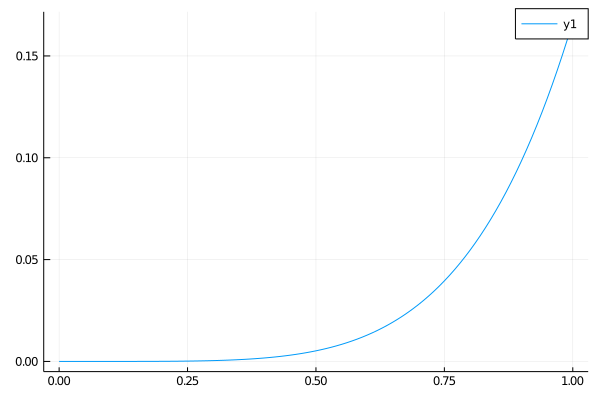

In [41]:
# Extract parameters
α = marginals[:θ].params[:a]

# Probability density function using the extracted parameters
pdfθ(θ) = prod(gamma.(α))/gamma(prod(α)) * prod(θ.^α)

# Visualizations are more difficult for a Dirichlet
θ_range = range(0, step=0.01, stop=1.0)
plot(θ_range, pdfθ.(θ_range))

### 4. Gut feeling questions

In [58]:
# Start building a model
factor_graph4 = FactorGraph()

# Add the prior
@RV θ ~ GaussianMeanVariance(3., 1., id=:prior)

# Add question 1 correctness likelihood
@RV Q1 ~ GaussianMeanVariance(θ, 0.5, id=:likelihood1)

# Add question 2 correctness likelihood
@RV Q2 ~ GaussianMeanVariance(θ, 0.5, id=:likelihood2)

# The question outcomes are going to be observed
placeholder(Q1, :Q1)
placeholder(Q2, :Q2)

# Visualize the graph
ForneyLab.draw(factor_graph4)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 6906095038142735597 -->
 
 6906095038142735597 
 
 𝒩 
 likelihood2 
 
<!-- 6489009948258815816 -->
 
 6489009948258815816 
 
 clamp_4 
 
<!-- 6906095038142735597--6489009948258815816 -->
 
 6906095038142735597--6489009948258815816 
 
 clamp_4 
 1 out 
 3 v 
 
<!-- 16874506189985157619 -->
 
 16874506189985157619 
 
 clamp_1 
 
<!-- 10753811581627226735 -->
 
 10753811581627226735 
 
 𝒩 
 likelihood1 
 
<!-- 18034932933586340110 -->
 
 18034932933586340110 
 
 clamp_3 
 
<!-- 10753811581627226735--18034932933586340110 -->
 
 10753811581627226735--18034932933586340110 
 
 clamp_3 
 1 out 
 3 v 
 
<!-- 16113655445414118406 -->
 
 16113655445414118406 
 
 placeholder_Q1 
 
<!-- 16113655445414118406--10753811581627226735 -->
 
 16113655445414118406--10753811581627226735 
 
 Q1 
 1 out 
 1 out 
 
<!-- 8792159407990422335 -->
 
 8792159407990422335 
 
 𝒩 
 prior 
 
<!-- 8792159407990422335--16874506189985157619 -->
 
 8792159407990422335--16874506189985157619 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 9288706912858520272 -->
 
 9288706912858520272 
 
 clamp_2 
 
<!-- 8792159407990422335--9288706912858520272 -->
 
 8792159407990422335--9288706912858520272 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 3272414949867544161 -->
 
 3272414949867544161 
 
 placeholder_Q2 
 
<!-- 3272414949867544161--6906095038142735597 -->
 
 3272414949867544161--6906095038142735597 
 
 Q2 
 1 out 
 1 out 
 
<!-- 12442304382718904406 -->
 
 12442304382718904406 
 
 = 
 equ_θ_1 
 
<!-- 12442304382718904406--6906095038142735597 -->
 
 12442304382718904406--6906095038142735597 
 
 θ 
 2 m 
 3 3 
 
<!-- 12442304382718904406--10753811581627226735 -->
 
 12442304382718904406--10753811581627226735 
 
 θ 
 2 m 
 2 2 
 
<!-- 12442304382718904406--8792159407990422335 -->
 
 12442304382718904406--8792159407990422335 
 
 θ 
 1 out 
 1 1

In [59]:
# Indicate which variables you want posteriors for
q = PosteriorFactorization(θ, ids=[:θ])

# Generate a message passing inference algorithm
algorithm = messagePassingAlgorithm(θ, q)

# Compile algorithm code
source_code = algorithmSourceCode(algorithm)

# Bring compiled code into current scope
eval(Meta.parse(source_code))
println(source_code)

# Visualize message passing schedule
pfθ = q.posterior_factors[:θ]
ForneyLab.draw(pfθ, schedule=pfθ.schedule);

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 6906095038142735597 -->
 
 6906095038142735597 
 
 𝒩 
 likelihood2 
 
<!-- 6489009948258815816 -->
 
 6489009948258815816 
 
<!-- 6906095038142735597--6489009948258815816 -->
 
 6906095038142735597--6489009948258815816 
 
 1 out 
 3 v 
 
<!-- 10753811581627226735 -->
 
 10753811581627226735 
 
 𝒩 
 likelihood1 
 
<!-- 18034932933586340110 -->
 
 18034932933586340110 
 
<!-- 10753811581627226735--18034932933586340110 -->
 
 10753811581627226735--18034932933586340110 
 
 1 out 
 3 v 
 
<!-- 8792159407990422335 -->
 
 8792159407990422335 
 
 𝒩 
 prior 
 
<!-- 16874506189985157619 -->
 
 16874506189985157619 
 
<!-- 8792159407990422335--16874506189985157619 -->
 
 8792159407990422335--16874506189985157619 
 
 1 out 
 2 m 
 
<!-- 9288706912858520272 -->
 
 9288706912858520272 
 
<!-- 8792159407990422335--9288706912858520272 -->
 
 8792159407990422335--9288706912858520272 
 
 1 out 
 3 v 
 
<!-- 12442304382718904406 -->
 
 12442304382718904406 
 
 = 
 equ_θ_1 
 
<!-- 12442304382718904406--6906095038142735597 -->
 
 12442304382718904406--6906095038142735597 
 
 θ 
 2 m 
 ((3)) 
 3 3 
 
<!-- 12442304382718904406--10753811581627226735 -->
 
 12442304382718904406--10753811581627226735 
 
 θ 
 2 m 
 ((2)) 
 2 2 
 
<!-- 12442304382718904406--8792159407990422335 -->
 
 12442304382718904406--8792159407990422335 
 
 θ 
 1 out 
 ((1)) 
 1 1 
 (4) 
 
<!-- 16113655445414118406 -->
 
 16113655445414118406 
 
<!-- 16113655445414118406--10753811581627226735 -->
 
 16113655445414118406--10753811581627226735 
 
 1 out 
 1 out 
 
<!-- 3272414949867544161 -->
 
 3272414949867544161 
 
<!-- 3272414949867544161--6906095038142735597 -->
 
 3272414949867544161--6906095038142735597 
 
 1 out 
 1 out

begin

function stepθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=3.0), ProbabilityDistribution(Univariate, PointMass, m=1.0))
messages[2] = ruleVBGaussianMeanVarianceM(ProbabilityDistribution(Univariate, PointMass, m=data[:Q1]), nothing, ProbabilityDistribution(Univariate, PointMass, m=0.5))
messages[3] = ruleVBGaussianMeanVarianceM(ProbabilityDistribution(Univariate, PointMass, m=data[:Q2]), nothing, ProbabilityDistribution(Univariate, PointMass, m=0.5))
messages[4] = ruleSPEqualityGaussian(nothing, messages[2], messages[3])

marginals[:θ] = messages[1].dist * messages[4].dist

return marginals

end

end # block


In [60]:
# Initialize a message data structure
messages = Array{Message}(undef, 4)

# Initalize marginal distributions data structure
marginals = Dict(:θ => ProbabilityDistribution(Univariate, GaussianMeanVariance, m=0.0, v=1.0))

# Suppose you got question 1 correct
data = Dict(:Q1 => 3.2,
            :Q2 => 4.5)

# Update coefficients
stepθ!(data, marginals, messages);

# Print messages
print("\nMessage ((1)) = "*string(messages[1].dist))
print("Message ((2)) = "*string(messages[2].dist))
print("Message ((3)) = "*string(messages[3].dist))
println("Message ((4)) = "*string(messages[4].dist))


Message ((1)) = 𝒩(m=3.00, v=1.00)
Message ((2)) = 𝒩(m=3.20, v=0.50)
Message ((3)) = 𝒩(m=4.50, v=0.50)
Message ((4)) = 𝒩(xi=15.40, w=4.00)



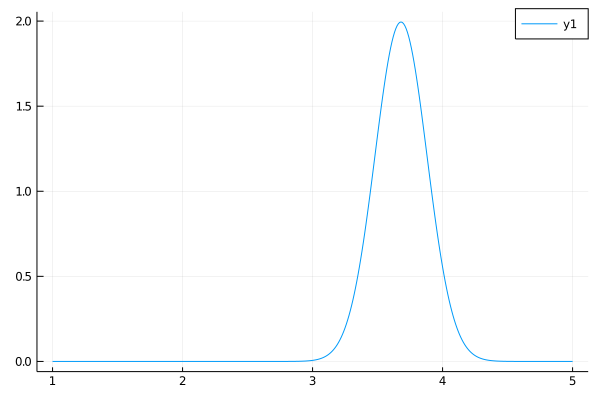

In [63]:
# Extract parameters
m = mean(marginals[:θ])
v = var(marginals[:θ])

# Probability density function using the extracted parameters
pdfθ(θ) = 1/sqrt(2*π*v^2)*exp(-(θ - m)^2/(2*v^2))

# Visualizations are more difficult for a Dirichlet
θ_range = range(1.0, step=0.01, stop=5.0)
plot(θ_range, pdfθ.(θ_range))